## Download dataset from Kaggle


In [ ]:
!pip install --upgrade --force-reinstall --no-deps kaggle
!cd /content/
api_token = {"username":"essux99","key":"b223d845353727089bbbdaae72bf1e1b"}
import json
import zipfile
import os
!mkdir '/root/.kaggle'
with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)
!chmod 600 /root/.kaggle/kaggle.json
!kaggle competitions download -c dog-breed-identification -p "/content/data"
!unzip -qq data/dog-breed-identification.zip -d data

     |████████████████████████████████| 61kB 3.2MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.6-cp36-none-any.whl size=72859 sha256=4e39c00ce89c4433e889e5da00c3cf7dfbb5e40508ad480d127f6b80d95a18fd
  Stored in directory: /root/.cache/pip/wheels/57/4e/e8/bb28d035162fb8f17f8ca5d42c3230e284c6aa565b42b72674
Successfully built kaggle
  Found existing installation: kaggle 1.5.6
    Uninstalling kaggle-1.5.6:
      Successfully uninstalled kaggle-1.5.6
100% 688M/691M [00:11<00:00, 76.3MB/s]
100% 691M/691M [00:11<00:00, 63.3MB/s]


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import numpy as np

## Split dataset in Train, Dev, Test

In [ ]:
import os
from glob import glob
import shutil
from math import floor

!rm -rf data/train/train data/train/test data/train/dev

labels_df = pd.read_csv('data/labels.csv').set_index('id')

root_path = 'data/train'

files = glob(root_path + "/*")

class_files = {}

# Returns a 3-tuple with train, dev and test data respectively
def train_dev_test_split(arr, train_size, dev_size):
    train_id = floor(len(arr)*train_size)
    test_id = floor(len(arr)*dev_size) + train_id
    return arr[:train_id], arr[test_id:], arr[train_id:test_id]

# Group photos by breed
for file in files:
  base_name = os.path.basename(file)
  identifier = os.path.splitext(base_name)[0]
  breed = labels_df.loc[identifier, 'breed']
  if breed not in class_files:
    class_files[breed] = []
  class_files[breed].append(file)

partition_names = ['train', 'dev', 'test']

# Split photos in new folders
for breed, files in class_files.items():
  partitions = train_dev_test_split(files, train_size=0.6, dev_size=0.2)
  for partition_name, partition_files in zip(partition_names, partitions):
    for partition_file in partition_files:
      base_name = os.path.basename(partition_file)
      new_path = os.path.join(root_path, partition_name, breed, base_name)
      new_folder = os.path.dirname(new_path)
      if not os.path.exists(new_folder):
        os.makedirs(new_folder)
      shutil.copyfile(partition_file, new_path)

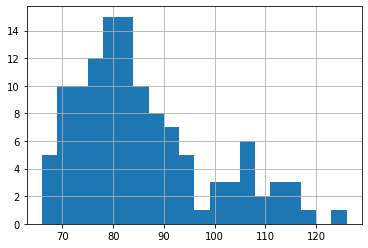

In [ ]:
labels_df.groupby('breed').size().hist(bins=20)

## Keras Data Generators and Data Augmentation

In [ ]:
import tensorflow.keras.applications.inception_v3 as inception_v3
from tensorflow.keras.preprocessing.image import ImageDataGenerator

BATCH_SIZE = 128
TRAIN_DIR = root_path + '/train'
DEV_DIR = root_path + '/dev'
TEST_DIR = root_path + '/test'

train_datagen = ImageDataGenerator(
    preprocessing_function=inception_v3.preprocess_input,
    rotation_range = 35,
    width_shift_range=0.15,
    height_shift_range=0.15,
    brightness_range=(0.8, 1),
    shear_range=30,
    zoom_range=0.2,
    channel_shift_range=50,
    horizontal_flip=True
)
dev_datagen = ImageDataGenerator(
    preprocessing_function=inception_v3.preprocess_input
)
test_datagen = ImageDataGenerator(
    preprocessing_function=inception_v3.preprocess_input
)

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)
    
dev_generator = dev_datagen.flow_from_directory(
    DEV_DIR,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    batch_size = BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 6090 images belonging to 120 classes.
Found 2131 images belonging to 120 classes.
Found 2001 images belonging to 120 classes.


## Sample of Training Data

In [ ]:
classes_names = [os.path.basename(x) for x in glob(root_path + '/train/*')]
classes_names.sort()

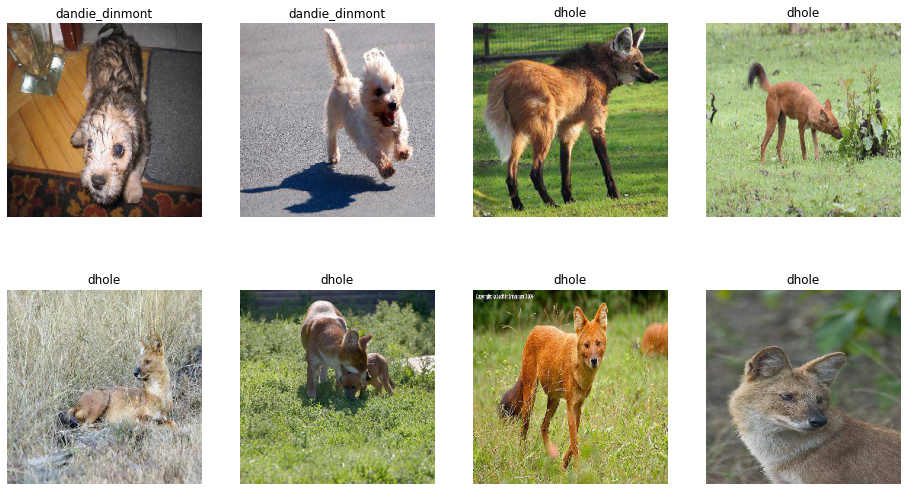

In [ ]:
x_batch, y_batch = next(dev_generator)


SHOW_SAMPLES = 8
plt.figure(figsize=(16, 9))
for k, (img, lbl) in enumerate(zip(x_batch[:SHOW_SAMPLES], y_batch[:SHOW_SAMPLES])):
    breed = classes_names[np.argmax(lbl)]
    plt.subplot(2, 4, k+1)
    plt.imshow((img + 1) / 2)
    plt.axis('off')
    plt.title(breed)

## Sample of Data Augmentation

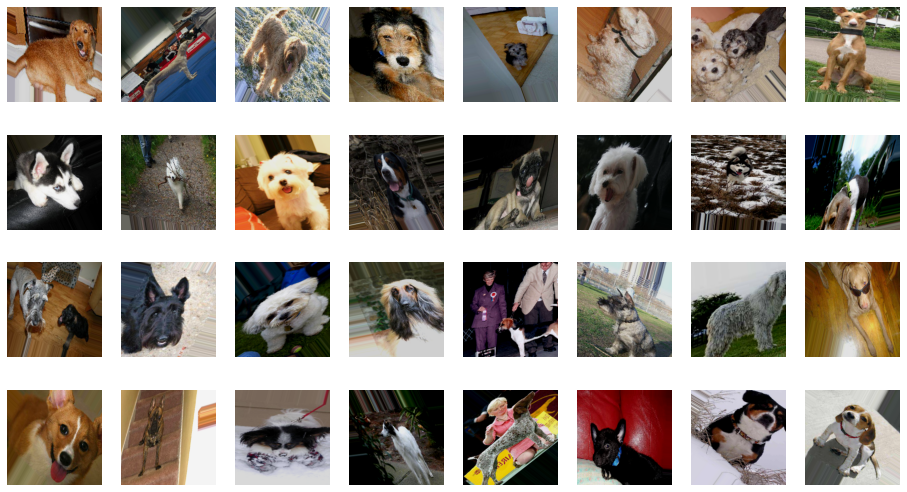

In [ ]:
x_batch, y_batch = next(train_generator)

SHOW_SAMPLES = 32
plt.figure(figsize=(16, 9))
for k, (img, lbl) in enumerate(zip(x_batch[:SHOW_SAMPLES], y_batch[:SHOW_SAMPLES])):
    plt.subplot(4, 8, k+1)
    plt.imshow((img + 1) / 2)
    plt.axis('off')

## Set up Model

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3

CLASSES = 120
    
# setup model
base_model = inception_v3.InceptionV3(
    weights='imagenet',
    include_top=False
)

# Only train last block
for layer in base_model.layers:
  layer.trainable = False
  #if layer.name == "mixed9": break

x = base_model.output
x = tf.keras.layers.GlobalMaxPooling2D(name='max_pool')(x)
x = tf.keras.layers.Dropout(0.4)(x)
x = tf.keras.layers.Dense(
    CLASSES,
    activation='softmax',
    activity_regularizer=tf.keras.regularizers.l1(0.01)
)(x)
predictions = x

model = Model(inputs=base_model.input, outputs=predictions)
optimizer = tf.keras.optimizers.Adam()
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy', 'top_k_categorical_accuracy'])

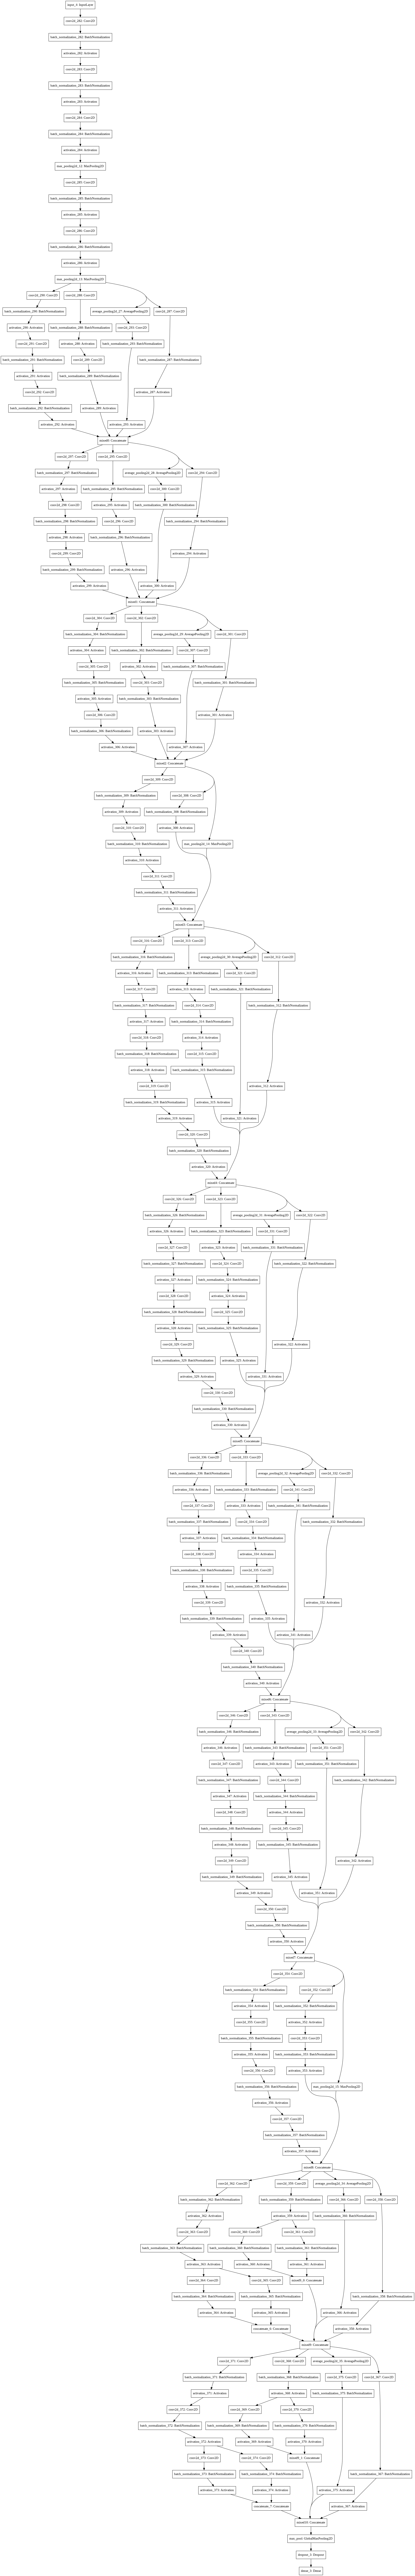

In [ ]:
tf.keras.utils.plot_model(model)

In [ ]:
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d_470 (Conv2D)             (None, None, None, 3 864         input_6[0][0]                    
__________________________________________________________________________________________________
batch_normalization_470 (BatchN (None, None, None, 3 96          conv2d_470[0][0]                 
__________________________________________________________________________________________________
activation_470 (Activation)     (None, None, None, 3 0           batch_normalization_470[0][0]    
____________________________________________________________________________________________

## Training 

In [ ]:
EPOCHS = 15

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5,
                              patience=3, min_lr=0.00001, verbose=1, min_delta=0.01)

history = model.fit(
    x=train_generator,
    epochs=EPOCHS,
    validation_data=dev_generator,
    callbacks=[reduce_lr]
)

Epoch 1/15
48/48 [==============================] - 152s 3s/step - loss: 6.5783 - accuracy: 0.1801 - top_k_categorical_accuracy: 0.3698 - val_loss: 1.2051 - val_accuracy: 0.6893 - val_top_k_categorical_accuracy: 0.9244 - lr: 0.0010
Epoch 2/15
48/48 [==============================] - 150s 3s/step - loss: 3.0618 - accuracy: 0.4780 - top_k_categorical_accuracy: 0.7616 - val_loss: 0.9273 - val_accuracy: 0.7593 - val_top_k_categorical_accuracy: 0.9592 - lr: 0.0010
Epoch 3/15
48/48 [==============================] - 151s 3s/step - loss: 2.6718 - accuracy: 0.5527 - top_k_categorical_accuracy: 0.8202 - val_loss: 0.8406 - val_accuracy: 0.8024 - val_top_k_categorical_accuracy: 0.9695 - lr: 0.0010
Epoch 4/15
48/48 [==============================] - 151s 3s/step - loss: 2.3831 - accuracy: 0.5947 - top_k_categorical_accuracy: 0.8534 - val_loss: 0.8563 - val_accuracy: 0.7973 - val_top_k_categorical_accuracy: 0.9723 - lr: 0.0010
Epoch 5/15
48/48 [==============================] - 152s 3s/step - loss:

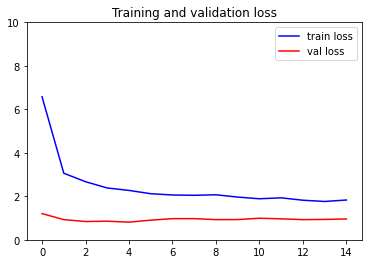

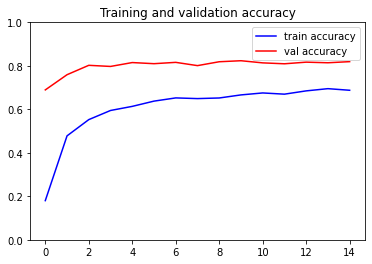

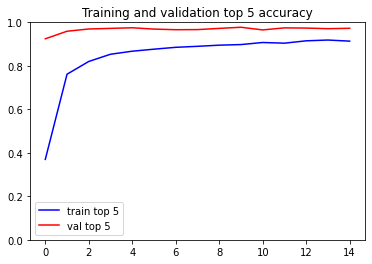

In [ ]:
def plot_training(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  topk = history.history['top_k_categorical_accuracy']
  val_topk = history.history['val_top_k_categorical_accuracy']
  epochs = range(len(acc))
  
  plt.figure()
  plt.plot(epochs, loss, 'b', label='train loss')
  plt.plot(epochs, val_loss, 'r', label='val loss')
  plt.title('Training and validation loss')
  plt.ylim(0, 10)
  plt.legend()
  plt.show()

  plt.plot(epochs, acc, 'b', label='train accuracy')
  plt.plot(epochs, val_acc, 'r', label='val accuracy')
  plt.title('Training and validation accuracy')
  plt.ylim(0, 1)
  plt.legend()  
  
  
  plt.figure()
  plt.plot(epochs, topk, 'b', label='train top 5')
  plt.plot(epochs, val_topk, 'r', label='val top 5')
  plt.title('Training and validation top 5 accuracy')
  plt.ylim(0, 1)
  plt.legend()
  plt.show()
  
plot_training(history)

In [ ]:
print('{:.4f} {:.4f}'.format(history.history['accuracy'][-1], history.history['val_accuracy'][-1]))

0.6877 0.8193


### Save Model 

In [ ]:
!mkdir /content/model
model.save('/content/model/model.h5')

## Test

In [ ]:
model.evaluate(test_generator)

16/16 [==============================] - 14s 873ms/step - loss: 1.0261 - accuracy: 0.7986 - top_k_categorical_accuracy: 0.9715


[1.026144027709961, 0.7986006736755371, 0.9715142250061035]

## Predictions to Submit on Kaggle

In [ ]:
!mkdir data/test/challenge
!mv data/test/*.jpg data/test/challenge

In [ ]:
CHALLENGE_DIR = '/content/data/test'

challenge_datagen = ImageDataGenerator(
    preprocessing_function=inception_v3.preprocess_input
)
    
challenge_generator = dev_datagen.flow_from_directory(
    CHALLENGE_DIR,
    batch_size=512,
    class_mode=None,
    shuffle=False
)

Found 10357 images belonging to 1 classes.


In [ ]:
challenge_generator.reset()
predictions = model.predict(challenge_generator, verbose=1)

21/21 [==============================] - 60s 3s/step


### Check Predictions with Photos from Google

Text(0.5, 1.0, 'sealyham_terrier')

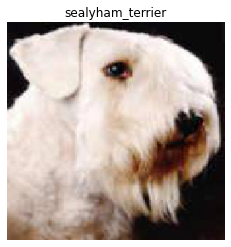

In [ ]:
challenge_generator.reset()
x_batch = next(challenge_generator)

SAMPLE_ID = 11
breed = classes_names[np.argmax(predictions[SAMPLE_ID])]
img = x_batch[SAMPLE_ID]
plt.figure(figsize=(4, 4))
plt.imshow((img + 1) / 2)
plt.axis('off')
plt.title(breed)

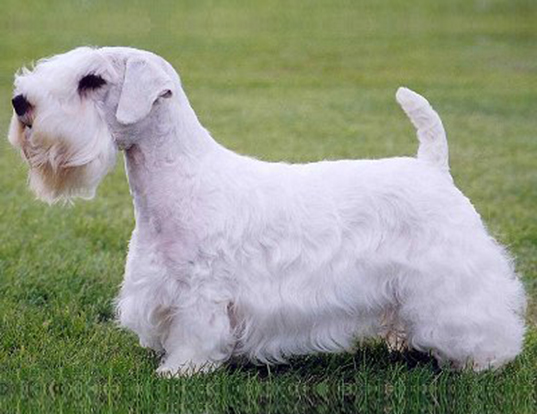

In [ ]:
%matplotlib inline
from IPython.display import Image
Image('https://www.worldlifeexpectancy.com/images/a/d/d/b/sealyham_terrier/sealyham_terrier_1.jpg')

### CSV File with Model Predictions

In [ ]:
challenge_ids = [os.path.basename(x)[:-4] for x in glob('data/test/challenge/*')]
challenge_ids.sort()

In [ ]:
df_results = pd.DataFrame(predictions, columns=classes_names, index=challenge_ids)
df_results.index.names = ['id']
df_results.to_csv('submission.csv')
df_results

,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,beagle,bedlington_terrier,bernese_mountain_dog,black-and-tan_coonhound,blenheim_spaniel,bloodhound,bluetick,border_collie,border_terrier,borzoi,boston_bull,bouvier_des_flandres,boxer,brabancon_griffon,briard,brittany_spaniel,bull_mastiff,cairn,cardigan,chesapeake_bay_retriever,chihuahua,chow,clumber,cocker_spaniel,collie,curly-coated_retriever,dandie_dinmont,dhole,dingo,doberman,english_foxhound,...,norwegian_elkhound,norwich_terrier,old_english_sheepdog,otterhound,papillon,pekinese,pembroke,pomeranian,pug,redbone,rhodesian_ridgeback,rottweiler,saint_bernard,saluki,samoyed,schipperke,scotch_terrier,scottish_deerhound,sealyham_terrier,shetland_sheepdog,shih-tzu,siberian_husky,silky_terrier,soft-coated_wheaten_terrier,staffordshire_bullterrier,standard_poodle,standard_schnauzer,sussex_spaniel,tibetan_mastiff,tibetan_terrier,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
000621fb3cbb32d8935728e48679680e,2.495546e-09,1.416108e-09,5.226585e-12,3.949911e-11,1.529808e-14,1.056581e-10,6.686759e-14,1.077809e-10,6.857008e-12,3.850584e-10,4.684620e-14,2.826469e-10,1.185646e-10,4.110126e-07,3.774235e-10,3.993893e-12,2.030536e-10,1.043886e-12,4.637016e-10,1.084434e-11,3.615628e-13,1.038262e-10,3.569216e-11,1.644894e-12,1.741591e-12,1.256944e-11,4.474830e-14,2.712002e-13,7.222285e-13,1.119282e-08,8.311080e-11,7.760953e-13,2.650294e-10,3.850993e-11,3.608932e-12,3.472694e-13,9.328384e-12,1.428807e-11,2.528878e-11,4.897483e-12,...,3.016088e-13,1.792219e-13,1.913744e-13,1.610873e-10,4.339952e-10,3.574625e-04,8.245254e-11,2.118095e-06,9.180118e-12,6.544933e-13,1.881525e-09,1.088942e-11,1.675380e-12,1.691336e-10,4.416108e-09,1.178133e-10,4.561748e-14,2.864260e-12,1.182379e-13,4.388880e-11,1.237089e-05,1.506708e-11,4.976123e-13,2.657268e-11,3.039097e-11,2.518490e-12,2.811913e-10,3.724574e-11,7.284813e-11,2.211972e-10,1.422196e-12,4.233702e-11,1.729182e-12,1.146088e-11,4.378125e-12,1.038533e-11,7.805370e-13,9.516534e-14,5.799480e-11,3.562670e-13
00102ee9d8eb90812350685311fe5890,7.108289e-08,2.224969e-09,4.652445e-09,3.900102e-10,3.052072e-10,8.661428e-09,9.288638e-12,4.820464e-08,9.926413e-10,4.587159e-10,1.487831e-09,1.690316e-08,1.136284e-08,4.176275e-09,4.773804e-10,1.590177e-09,1.972872e-07,2.756175e-11,2.373312e-08,3.558209e-10,4.057362e-09,1.944763e-08,6.909846e-11,1.596590e-09,2.898615e-09,1.934008e-10,2.024038e-09,1.011200e-10,1.911994e-09,3.118502e-10,2.447514e-06,5.373683e-10,7.263229e-11,1.230485e-08,6.076512e-10,4.878683e-11,2.136164e-09,4.087352e-09,3.471962e-09,1.246310e-09,...,3.982627e-10,3.209497e-09,3.549629e-09,5.280210e-10,1.309080e-09,1.419868e-10,8.793045e-09,1.215229e-06,2.884707e-08,1.295266e-09,1.282943e-09,8.935357e-11,1.078066e-07,3.253315e-11,9.990164e-01,1.059135e-08,2.579100e-09,1.606676e-10,2.450951e-09,1.052658e-09,1.596665e-10,1.617153e-06,1.691659e-10,5.339376e-10,1.150956e-10,1.604463e-09,3.870728e-09,1.325829e-08,7.511589e-08,8.946031e-11,3.816098e-10,3.200599e-11,1.753840e-11,6.478587e-10,3.132556e-08,2.030095e-11,2.247786e-07,1.715162e-11,1.106991e-09,2.829409e-11
0012a730dfa437f5f3613fb75efcd4ce,1.213342e-14,2.531129e-04,7.849212e-11,2.460704e-11,7.690713e-12,2.344363e-12,2.104742e-13,4.638392e-12,1.074831e-13,4.978085e-14,4.305491e-16,6.162993e-12,2.109777e-10,1.099271e-08,1.432863e-10,9.721017e-10,9.523898e-12,1.016461e-11,5.130216e-09,2.980621e-16,9.267600e-14,1.526199e-11,2.289257e-12,5.033256e-08,2.890661e-07,6.661809e-10,7.097771e-12,2.397878e-14,9.643067e-14,1.206133e-11,1.916422e-13,5.216950e-06,1.003607e-07,5.099782e-11,6.493716e-13,3.046505e-13,1.488375e-12,6.586096e-13,1.453373e-12,2.754519e-10,...,6.434087e-15,1.375343e-13,4.293224e-16,9.840091e-10,1.586275e-12,3.187605e-09,5.89